### Resources

**Load Images**
- https://huggingface.co/docs/datasets/use_with_pytorch
- https://huggingface.co/docs/datasets/v2.14.5/en/image_load

**Process images:**
- image processing: https://huggingface.co/docs/datasets/image_process#map
- transforms methods: https://pytorch.org/vision/stable/transforms.html#transforms
- HF general processing: https://huggingface.co/docs/datasets/process
- transforms v2 reference: https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

**Test/Train split**
- use this: https://huggingface.co/docs/datasets/v2.15.0/en/package_reference/main_classes#datasets.Dataset.train_test_split

**PyTorch Classification Tutorial**
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

**Building a Model Basics**
- https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datasets 
from datasets import Features, Image, load_dataset, load_dataset_builder, config, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import os

import shutil
import pathlib
import PIL
from PIL import Image

import torch
import torchvision
from torchvision.transforms import v2, ToTensor, Lambda
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix

Matplotlib created a temporary cache directory at /tmp/matplotlib-_3suv3sz because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# check for GPU and create the device object
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [3]:
# get data (from https://huggingface.co/datasets/YakupAkdin/instrument-images/tree/main)

# import data (specifying GPU on 
dataset = load_dataset("YakupAkdin/instrument-images", split='train').with_format('torch', device=device)

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
# define our labels
label_values = {
    0: 'harp',
    1: 'baglama',
    2: 'electric guitar',
    3: 'acoustic guitar',
    4: 'kanun',
    5: 'violin',
    6: 'kemence',
    7: 'mandolin',
    8: 'oud',
    9: 'yayli tambur'}

inverted_labels = {v: k for k, v in label_values.items()}

In [5]:
# create a pandas copy for easier PIL exploration
df_clone = dataset.to_pandas()
df_clone = df_clone.assign(
    desc = df_clone.label.map(label_values),
    image = df_clone.image.apply(lambda x: x['path']))
df_clone.head()

,image,label,desc
0,/workspace/hf_cache/downloads/c1788b27609c6ad9...,0,harp
1,/workspace/hf_cache/downloads/8f8cdb21c6698ee6...,0,harp
2,/workspace/hf_cache/downloads/41f7f4b3f28c4ede...,0,harp
3,/workspace/hf_cache/downloads/4bce77de0a7870be...,0,harp
4,/workspace/hf_cache/downloads/e5502c68bcbbc862...,0,harp


0 : harp


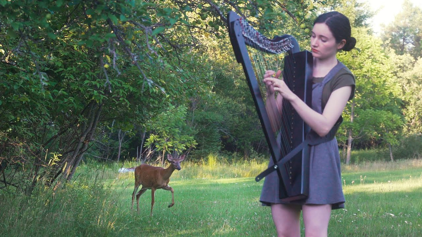

3 : acoustic guitar


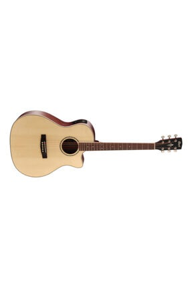

6 : kemence


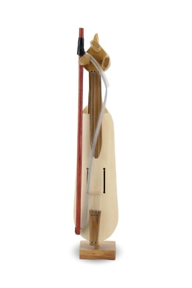

9 : yayli tambur


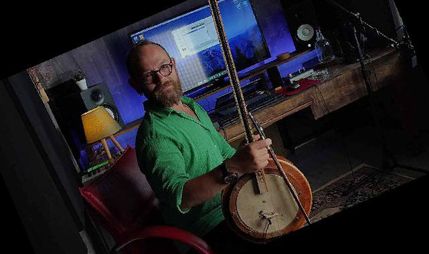

In [6]:
# view the first image and label
def img_check(i, scale):
    print(df_clone.label[i],':',df_clone.desc[i])
    img = PIL.Image.open(df_clone.image[i])
    img = img.resize((int(img.size[0]/(100/scale)), int(img.size[1]/(100/scale))))
    img.show()

img_check(0, 33)
img_check(333, 67)
img_check(666, 67)
img_check(999, 67)

In [7]:
# isolate RGB images for pre processing
dataset_RGB = dataset.filter(lambda x: x['image'].dim() == 3)
len(dataset_RGB)

989

In [8]:
# the RGB images are [H,W,3] and PyTorch needs them as [3,H,W]
# included [:3, :, :] slice to adjust any RGBA images to RGB
print(dataset_RGB[0]['image'].shape)

# permute the tensors
def permute_images(batch):
    # Apply the permute operation to each tensor in the batch
    batch['image'] = [img.permute(2, 0, 1)[:3, :, :] for img in batch['image']]
    return batch

dataset_RGB = dataset_RGB.map(permute_images, batched=True, batch_size=20)

dataset_RGB[0]['image'].shape

torch.Size([720, 1280, 3])


Map:   0%|          | 0/989 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


torch.Size([3, 720, 1280])

In [9]:
dataset_greyscale = dataset.filter(lambda x: x['image'].dim() == 2)
len(dataset_greyscale)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

11

In [10]:
# some of the images are greyscale, so we convert to RGB as well
print(dataset_greyscale[0]['image'].shape)

def grayscale_to_rgb(item):
    item['image'] = item['image'].unsqueeze(0).repeat(3, 1, 1)
    return item

dataset_greyscale = dataset_greyscale.map(grayscale_to_rgb)
print(dataset_greyscale[0]['image'].shape)

torch.Size([849, 900])


Map:   0%|          | 0/11 [00:00<?, ? examples/s]

torch.Size([3, 849, 900])


In [11]:
# concatenate both reformatted RGB datasets
dataset = concatenate_datasets([dataset_RGB, dataset_greyscale])

In [12]:
# confirming 0-255 scaling and int dtype of image tensors
sample_image = dataset[0]['image']

print('Tensor dtype:', sample_image.dtype)
print("Sample values:", sample_image.flatten()[:10])
print("Max value:", sample_image.max().item())
print("Min value:", sample_image.min().item())

Tensor dtype: torch.int64
Sample values: tensor([40, 39, 41, 41, 41, 44, 48, 53, 54, 52], device='cuda:0')
Max value: 255
Min value: 0


In [13]:
# compose transformation function
def scale_tensor(tensor):
    return tensor.float() / 255

basic_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True), # resize for model requirements
    v2.RandomHorizontalFlip(p=0.5),
    scale_tensor, # converts to [0, 1] float dtype
    v2.Lambda(lambda x: torch.clamp(x, 0, 1)),  # clamp max values to 1 before normalization
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # required normalization for resnet
])

# application function for transforms
def apply_transform(example):
    # Apply the transformation to the 'image' field
    example['image'] = [basic_transform(img) for img in example['image']]
    return example

# apply transforms
dataset = dataset.map(apply_transform, batched=True, batch_size=100)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [14]:
# quick check on the transform
sample_image = dataset[0]['image']

print('Tensor dtype:', sample_image.dtype)
print('Sample values:', sample_image.flatten()[0:10])
print('Max value:', sample_image.max().item())
print('Min value:', sample_image.min().item())

Tensor dtype: torch.float32
Sample values: tensor([-0.9705, -1.0562, -1.2959, -1.2103, -1.0733, -0.8678, -0.6623, -0.6623,
        -0.3027,  0.5878], device='cuda:0')
Max value: 2.341036796569824
Min value: -1.8267831802368164


### Examine Dataset/Model Compatibility Before Training

In [15]:
# are all tensors shape [3, 224, 224]?

correct_tensor_shape = 0

for i in range(len(dataset)):
    if dataset[i]['image'].shape != torch.Size([3, 224, 224]):
        print(f"Image at index {i} has incorrect shape: {image.shape}")
    else:
        correct_tensor_shape += 1

print(correct_tensor_shape)

1000


2 : electric guitar


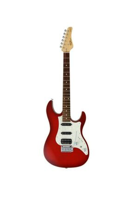

2 : electric guitar


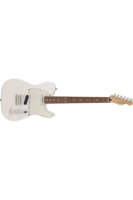

2 : electric guitar


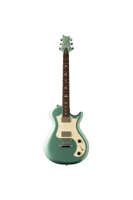

2 : electric guitar


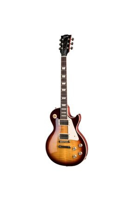

2 : electric guitar


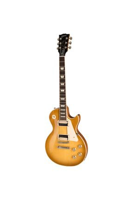

7 : mandolin


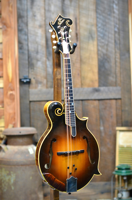

7 : mandolin


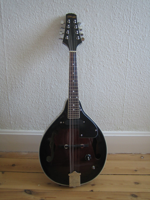

7 : mandolin


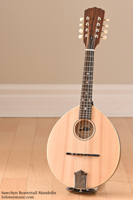

7 : mandolin


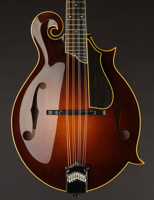

7 : mandolin


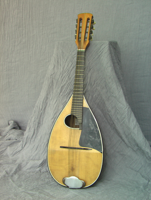

8 : oud


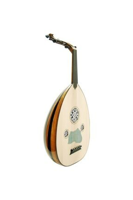

8 : oud


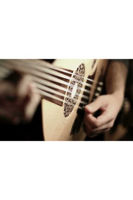

8 : oud


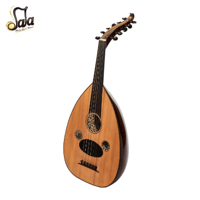

8 : oud


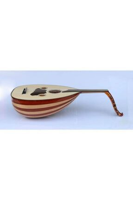

8 : oud


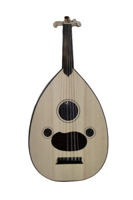

4 : kanun


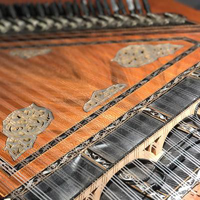

4 : kanun


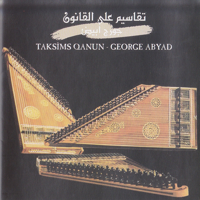

4 : kanun


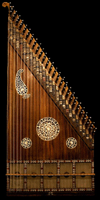

4 : kanun


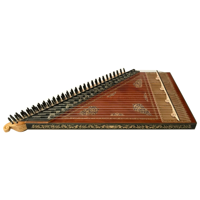

4 : kanun


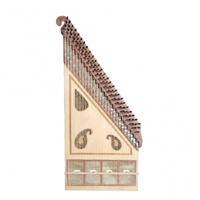

In [16]:
# are labels and images consistent?

#function to print a random x images/labels for a given instrument
def check_instrument(instrument, sample_size):    
    check = df_clone.loc[df_clone.desc == instrument].sample(sample_size).reset_index()
    for row in range(sample_size):
        image = check.image[row]
        img = PIL.Image.open(image).convert('RGB')
        img = img.resize((max(1, int(img.size[0] * 200 / img.size[1])), 200))
        print(check.label[row],':', check.desc[row])
        img.show()        

# check some images
check_instrument('electric guitar', 5)
check_instrument('mandolin', 5)
check_instrument('oud', 5)
check_instrument('kanun', 5)

### Dataloader Setup

In [19]:
# split test/train
dataset = dataset.train_test_split(test_size=0.2, seed=1, stratify_by_column="label")

In [23]:
batch_size = 4

trainloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=False, num_workers=0)
testloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, num_workers=0)

**replacing tutorial model with pre-trained [resnet 18](https://arxiv.org/abs/1512.03385)**

In [77]:
# set a cache in our Docker workspace
os.environ['TORCH_HOME'] = os.getcwd()

# import
from torchvision.models import resnet18, ResNet18_Weights

In [88]:
# load model with weights (only one option)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.IMAGENET1K_V1)

Using cache found in /workspace/hub/pytorch_vision_v0.10.0


In [89]:
# modifying the final layer to suit our 10 classes
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# freeze layers that aren't final fully connected layer
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad=False

# back on the GPU, set to eval
model = model.eval()
model = model.to(device)

In [90]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Testing Model before Fine Tuning

In [91]:
# create iterator
dataiter = iter(testloader)

In [92]:
# iterate through the test batch (could use training images too, we have not fine tuned yet)
def testbatch():
    batch = next(dataiter)
    images = batch['image']
    labels = batch['label']

# test the model output on these images
    with torch.no_grad():
        outputs = model(images)
    actual = [label_values[lbl.item()] for lbl in labels]
    predicted = [label_values[i.item()] for i in torch.max(outputs, 1)[1]]
    print('predicted: '+', '.join(predicted))
    print('actual: '+', '.join(actual))
    print(' ')

testbatch()
testbatch()
testbatch()

predicted: kemence, oud, violin, mandolin
actual: kemence, violin, violin, baglama
 
predicted: mandolin, acoustic guitar, mandolin, mandolin
actual: yayli tambur, oud, baglama, violin
 
predicted: mandolin, mandolin, baglama, mandolin
actual: kemence, baglama, acoustic guitar, yayli tambur
 


In [93]:
# calculate accuracy
correct = 0
total = 0

for data in testloader:
    images = data['image']
    labels = data['label']
    with torch.no_grad():
        outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'{correct} of {total} images categorized correctly: {100 * correct // total} %')

17 of 200 images categorized correctly: 8 %


In [94]:
# creating a confusion matrix
true_label = []
pred_label = []

# with torch.no_grad():
for batch in testloader:
    images = batch['image']
    labels = batch['label']
    with torch.no_grad():
        output = model(images)
    _, predicted = torch.max(output, 1)

    true_label.extend(labels.tolist())
    pred_label.extend(predicted.tolist())

In [95]:
# generate confusion matrix
cm = confusion_matrix(true_label, pred_label)

In [96]:
# get labels from dictionary
label_keys = sorted(label_values.keys())  
label_list = [label_values[key] for key in label_keys]

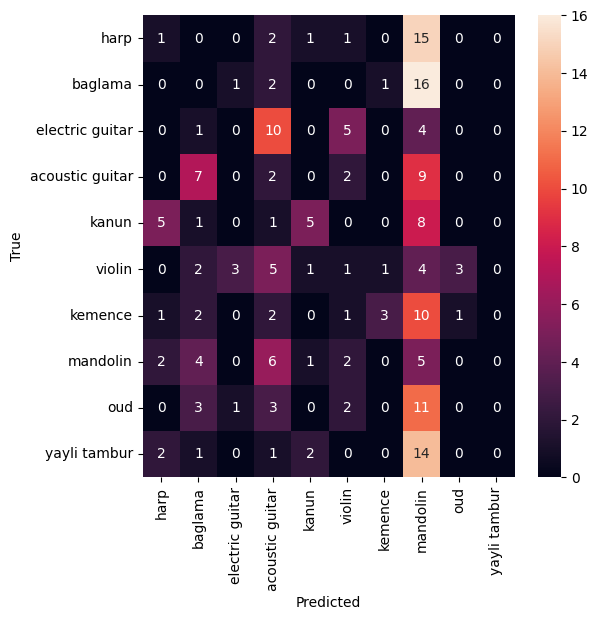

In [97]:
# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Fine Tuning the Model

In [99]:
# Define loss function: Classification Cross-Entropy loss and SGD with momentum.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # unchanged from tutorial

### Training Loop with logging for loss, accuracy, and model state

In [53]:
training_log = {'epoch': [], 'loss' : [], 'train_acc': [], 'test_acc': [], 'model_state': []}

for epoch in range(20):
    
    # set baseline for epoch
    running_loss = 0.0
    train_labels, train_pred = [], []
    model.train()

    # loop through each batch of the training dataloader
    for i, data in enumerate(trainloader, 0):
        inputs = data['image']
        labels = data['label']
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # catalog training results
        _, predicted = torch.max(outputs, 1)
        train_labels.append(labels.cpu())
        train_pred.append(predicted.cpu())
        
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            training_log['loss'].append(running_loss/200) # log the epoch loss before resetting it
            running_loss = 0.0

    # training results lists into tensors and calculate training accuracy
    train_labels = torch.cat(train_labels)
    train_pred = torch.cat(train_pred)
    train_acc = (train_pred == train_labels).sum().item() / train_labels.size(0)

    # test model after each training epoch
    test_labels, test_pred = [], []
    model.eval()
    
    for i, data in enumerate(testloader, 0):
        inputs = data['image']
        labels = data['label']
        outputs = model(inputs)

        # catalog test results
        _, predicted = torch.max(outputs, 1)
        test_labels.append(labels.cpu())
        test_pred.append(predicted.cpu())

    # test results lists into tensors and calculate test accuracy
    test_labels = torch.cat(test_labels)
    test_pred = torch.cat(test_pred)    
    test_acc = (test_pred == test_labels).sum().item() / test_labels.size(0)
    
    # add epoch details to training log
    training_log['epoch'].append(epoch) # epoch number
    training_log['train_acc'].append(train_acc) # training accuracy
    training_log['test_acc'].append(test_acc) # test accuracy

    # save the model
    cwd = os.getcwd()
    filename = f'model_state_epoch_{epoch}.pth'
    path = os.path.join(cwd, filename)
    torch.save(model.state_dict(), path)
    training_log['model_state'].append(path)

# https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

,image,label,desc
0,/workspace/hf_cache/downloads/c1788b27609c6ad9...,0,harp
1,/workspace/hf_cache/downloads/8f8cdb21c6698ee6...,0,harp
2,/workspace/hf_cache/downloads/41f7f4b3f28c4ede...,0,harp
3,/workspace/hf_cache/downloads/4bce77de0a7870be...,0,harp
4,/workspace/hf_cache/downloads/e5502c68bcbbc862...,0,harp


In [61]:
# view the training results as a dataframe
training_results = pd.DataFrame.from_dict(training_log)
training_results.head()

NameError: name 'training_log' is not defined

### Saving and Testing the Model

#### Evaluation steps
- make a confusion matrix with the best performing model state
- chart the accuracies and loss over each epoch
- throw in test images from wikipedia and various other sources (my guitars)

### Check Model Performance on Test Dataset

In [ ]:
# # examine images that were predicted correctly and incorrectly
# def add_predictions(example, i):
#     example['predicted_label'] = pred_label[i]
#     return example

# test_results = dataset['test'].map(add_predictions, with_indices=True)

# test_pass = test_results.filter(lambda x: x['label'] == x['predicted_label'])
# test_fail = test_results.filter(lambda x: x['label'] != x['predicted_label'])

In [ ]:
# def check_results(ds, limit):

#     images = ds['image'][0:limit]
#     labels = ds['label'][0:limit]
#     predict = ds['predicted_label'][0:limit]

#     label_list = ''
#     for i, lbl in enumerate(labels):
#         true = label_values[labels[i].item()]
#         pred = label_values[predict[i].item()]
#         print(f'actual: {true} | predicted: {pred}')
#         plt.figure(figsize=(1, 1))
#         imshow(images[i])

In [ ]:
# check_results(test_fail, 20)